# K-Nearest Neighbors Model Training

This notebook trains a KNN classifier for mobile price classification.

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load data
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

X_train = train_df.drop('price_range', axis=1)
y_train = train_df['price_range']
X_test = test_df.drop('price_range', axis=1)
y_test = test_df['price_range']

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (1600, 20)
Test set: (400, 20)


In [3]:
# Preprocessing - Scaling is crucial for KNN!
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())  # Essential for distance-based algorithms
    ]), numeric_cols)],
    remainder='drop'
)

print("Note: StandardScaler is essential for KNN as it's distance-based")

Note: StandardScaler is essential for KNN as it's distance-based


In [4]:
# Hyperparameter tuning
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', KNeighborsClassifier())
])

param_grid = {
    'clf__n_neighbors': [3, 5, 7, 9, 11, 15, 20],
    'clf__weights': ['uniform', 'distance'],
    'clf__metric': ['euclidean', 'manhattan', 'minkowski'],
    'clf__p': [1, 2]  # p=1 for manhattan, p=2 for euclidean
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
print("Starting hyperparameter tuning...")
grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

Starting hyperparameter tuning...
Fitting 5 folds for each of 84 candidates, totalling 420 fits

Best parameters: {'clf__metric': 'manhattan', 'clf__n_neighbors': 20, 'clf__p': 1, 'clf__weights': 'distance'}
Best CV score: 0.6363


In [5]:
# Evaluate
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.6500

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       100
           1       0.57      0.55      0.56       100
           2       0.54      0.55      0.54       100
           3       0.74      0.73      0.73       100

    accuracy                           0.65       400
   macro avg       0.65      0.65      0.65       400
weighted avg       0.65      0.65      0.65       400



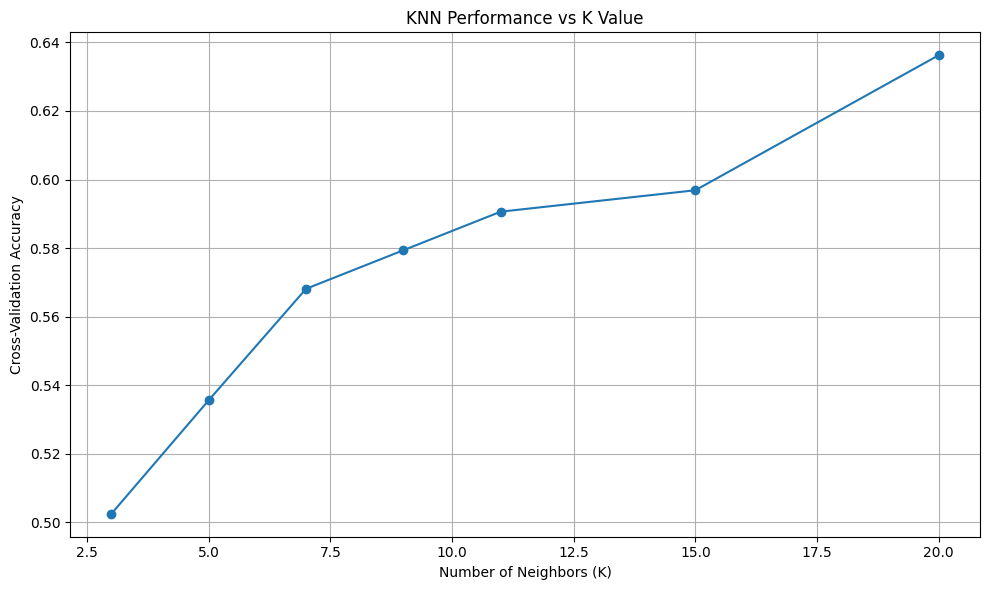

In [6]:
# Analyze performance by K value
results = grid_search.cv_results_
k_values = [params['clf__n_neighbors'] for params in results['params']]
mean_scores = results['mean_test_score']

# Group by k and get best score for each k
k_performance = {}
for k, score in zip(k_values, mean_scores):
    if k not in k_performance or score > k_performance[k]:
        k_performance[k] = score

plt.figure(figsize=(10, 6))
plt.plot(sorted(k_performance.keys()), [k_performance[k] for k in sorted(k_performance.keys())], marker='o')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Cross-Validation Accuracy')
plt.title('KNN Performance vs K Value')
plt.grid(True)
plt.tight_layout()
plt.show()

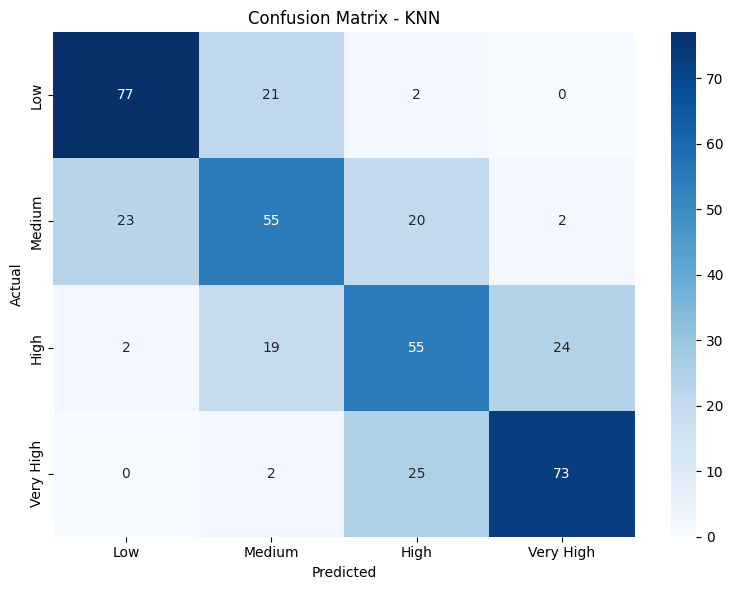

In [7]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'Medium', 'High', 'Very High'],
            yticklabels=['Low', 'Medium', 'High', 'Very High'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - KNN')
plt.tight_layout()
plt.show()

In [8]:
# Save model
joblib.dump(best_model, 'saved_models/K-Nearest_Neighbors_model.joblib')
print("Model saved to saved_models/K-Nearest_Neighbors_model.joblib")

Model saved to saved_models/K-Nearest_Neighbors_model.joblib
